In [2]:
# Importing libraries
import wget
import zipfile
import os
import json
from PIL import Image
import cv2
import matplotlib.pyplot as plt

## Downloading, re-organizing and filtering the COCO2017 Dataset.

### Download and unzip the COCO2017 dataset. This is a fairly large dataset, so it will take a while.

In [3]:
# COCO 2017 dataset URLs
train_images_url = "http://images.cocodataset.org/zips/train2017.zip"
val_images_url = "http://images.cocodataset.org/zips/val2017.zip"
annotations_url = "http://images.cocodataset.org/annotations/annotations_trainval2017.zip"

# Download the COCO 2017 dataset files
wget.download(train_images_url, "train2017.zip")
wget.download(val_images_url, "val2017.zip")
wget.download(annotations_url, "annotations_trainval2017.zip")

with zipfile.ZipFile("train2017.zip", "r") as zip_ref:
    zip_ref.extractall("train2017")

with zipfile.ZipFile("val2017.zip", "r") as zip_ref:
    zip_ref.extractall("val2017")

with zipfile.ZipFile("annotations_trainval2017.zip", "r") as zip_ref:
    zip_ref.extractall("annotations")


### Re-organize the structure of the dataset to satisfy the YOLO dataset structure.

In [1]:
!mkdir coco2017
%cd coco2017
!mkdir images
%cd ..

# Rename the folders
!mv train2017 train
!mv val2017 val

# Move the folders to the coco2017 folder
!mv train coco2017/images
!mv val coco2017/images
!mv annotations coco2017

In [5]:
!mv coco2017/images/train2017 coco2017/images/train
!mv coco2017/images/val2017 coco2017/images/val

### Filter the dataset, keep what we need. 

Set the target classes here. If you want to change the total number of the detection class, please also update the custom_data.yaml and custom_yolov5l.yaml

In [3]:
target_classes = ["person", "bottle", "laptop", "microwave", "cell phone", "book", "bed", "dining table", "chair", "toothbrush"]

coco_class_ids = {
    'person': 0, 'bicycle': 1, 'car': 2, 'motorcycle': 3, 'airplane': 4,
    'bus': 5, 'train': 6, 'truck': 7, 'boat': 8, 'traffic light': 9,
    'fire hydrant': 10, 'stop sign': 11, 'parking meter': 12, 'bench': 13,
    'bird': 14, 'cat': 15, 'dog': 16, 'horse': 17, 'sheep': 18,
    'cow': 19, 'elephant': 20, 'bear': 21, 'zebra': 22,
    'giraffe': 23, 'backpack': 24, 'umbrella': 25, 'handbag': 26,
    'tie': 27, 'suitcase': 28, 'frisbee': 29, 'skis': 30, 'snowboard': 31,
    'sports ball': 32, 'kite': 33, 'baseball bat': 34, 'baseball glove': 35,
    'skateboard': 36, 'surfboard': 37, 'tennis racket': 38, 'bottle': 39,
    'wine glass': 40, 'cup': 41, 'fork': 42, 'knife': 43, 'spoon': 44,
    'bowl': 45, 'banana': 46, 'apple': 47, 'sandwich': 48, 'orange': 49,
    'broccoli': 50, 'carrot': 51, 'hot dog': 52, 'pizza': 53,
    'donut': 54, 'cake': 55, 'chair': 56, 'couch': 57, 'potted plant': 58,
    'bed': 59, 'dining table': 60, 'toilet': 61, 'tv': 62, 'laptop': 63,
    'mouse': 64, 'remote': 65, 'keyboard': 66, 'cell phone': 67,
    'microwave': 68, 'oven': 69, 'toaster': 70, 'sink': 71, 'refrigerator': 72,
    'book': 73, 'clock': 74, 'vase': 75, 'scissors': 76, 'teddy bear': 77,
    'hair drier': 78, 'toothbrush': 79
}

target_class_ids = [coco_class_ids[name] for name in target_classes]

Filter the COCO annotations here.

In [7]:
def filter_coco_json(input_json_path, output_json_path, target_classes):
    with open(input_json_path, "r") as file:
        data = json.load(file)

    # Filter categories
    data["categories"] = [category for category in data["categories"] if category["name"] in target_classes]

    # Filter annotations
    category_ids = {category["id"] for category in data["categories"]}
    data["annotations"] = [annotation for annotation in data["annotations"] if annotation["category_id"] in category_ids]

    with open(output_json_path, "w") as file:
        json.dump(data, file, indent=2)

input_train_json_path = "coco2017/annotations/instances_train2017.json"
input_val_json_path = "coco2017/annotations/instances_val2017.json"

output_train_json_path = "coco2017/annotations/instances_train2017_filtered.json"
output_val_json_path = "coco2017/annotations/instances_val2017_filtered.json"

filter_coco_json(input_train_json_path, output_train_json_path, target_classes)
filter_coco_json(input_val_json_path, output_val_json_path, target_classes)

Convert the COCO annotations to YOLO bounding boxes.

In [8]:
def coco_to_yolo_bbox(coco_bbox, img_width, img_height):
    x, y, width, height = coco_bbox
    x_center = x + width / 2
    y_center = y + height / 2

    x_center /= img_width
    y_center /= img_height
    width /= img_width
    height /= img_height

    return x_center, y_center, width, height

In [9]:
def convert_annotations(input_json_path, images_dir, output_labels_dir):
    with open(input_json_path, "r") as file:
        data = json.load(file)

    id_to_category = {category["id"]: category["name"] for category in data["categories"]}
    id_to_category = {k: v for k, v in id_to_category.items() if v in target_classes}

    annotations = {}
    for annotation in data["annotations"]:
        if annotation["category_id"] not in id_to_category:
            continue

        image_id = annotation["image_id"]
        if image_id not in annotations:
            annotations[image_id] = []

        img_data = [item for item in data["images"] if item["id"] == image_id][0]
        img_width, img_height = img_data["width"], img_data["height"]

        category_id = id_to_category[annotation["category_id"]]
        yolo_class_id = target_class_ids.index(coco_class_ids[category_id])

        bbox = annotation["bbox"]
        yolo_bbox = coco_to_yolo_bbox(bbox, img_width, img_height)

        annotations[image_id].append((yolo_class_id, *yolo_bbox))

    for image_data in data["images"]:
        image_id = image_data["id"]
        if image_id not in annotations:
            continue

        img_filename = image_data["file_name"]
        txt_filename = img_filename.replace(".jpg", ".txt")
        txt_filepath = os.path.join(output_labels_dir, txt_filename)
        

        with open(txt_filepath, "w") as file:
            for annotation in annotations[image_id]:
                file.write(" ".join(str(x) for x in annotation) + "\n")

In [10]:
input_train_json_path = "coco2017/annotations/instances_train2017_filtered.json"
input_val_json_path = "coco2017/annotations/instances_val2017_filtered.json"

train_images_dir = "coco2017/images/train"
val_images_dir = "coco2017/images/val/"

output_train_labels_dir = "coco2017/labels/train"
output_val_labels_dir = "coco2017/labels/val"

os.makedirs(output_train_labels_dir, exist_ok=True)
os.makedirs(output_val_labels_dir, exist_ok=True)

convert_annotations(input_train_json_path, train_images_dir, output_train_labels_dir)
convert_annotations(input_val_json_path, val_images_dir, output_val_labels_dir)

### Since we filtered the annotations, we need to remove the images that do not have corresponding annotations

In [17]:
def remove_unmatched_images(images_folder, txt_folder):
    # List all .jpg files in the images folder
    image_files = [f for f in os.listdir(images_folder) if f.endswith('.jpg')]

    # List all .txt files in the txt folder
    txt_files = [f for f in os.listdir(txt_folder) if f.endswith('.txt')]

    # Convert .txt file names to .jpg names
    txt_files_jpg = [f.replace('.txt', '.jpg') for f in txt_files]

    # Find and remove .jpg files that do not have corresponding .txt files
    for image_file in image_files:
        if image_file not in txt_files_jpg:
            image_path = os.path.join(images_folder, image_file)
            os.remove(image_path)
            print(f"Removed: {image_path}")

# Replace the paths below with your actual folder paths
images_folder1 = 'coco2017/images/train'
txt_folder1 = 'coco2017/labels/train'
remove_unmatched_images(images_folder1, txt_folder1)

images_folder2 = 'coco2017/images/val'
txt_folder2 = 'coco2017/labels/val'
remove_unmatched_images(images_folder2, txt_folder2)

Removed: coco2017/images/train/000000050482.jpg
Removed: coco2017/images/train/000000504093.jpg
Removed: coco2017/images/train/000000285214.jpg
Removed: coco2017/images/train/000000374249.jpg
Removed: coco2017/images/train/000000507516.jpg
Removed: coco2017/images/train/000000099922.jpg
Removed: coco2017/images/train/000000526840.jpg
Removed: coco2017/images/train/000000110634.jpg
Removed: coco2017/images/train/000000055460.jpg
Removed: coco2017/images/train/000000437167.jpg
Removed: coco2017/images/train/000000006810.jpg
Removed: coco2017/images/train/000000150920.jpg
Removed: coco2017/images/train/000000140080.jpg
Removed: coco2017/images/train/000000318533.jpg
Removed: coco2017/images/train/000000549766.jpg
Removed: coco2017/images/train/000000174511.jpg
Removed: coco2017/images/train/000000566724.jpg
Removed: coco2017/images/train/000000170451.jpg
Removed: coco2017/images/train/000000208919.jpg
Removed: coco2017/images/train/000000554075.jpg
Removed: coco2017/images/train/000000000

Let's see an example.

In [16]:
def draw_bounding_box(image_path, txt_file_path):
    # Read the image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert color from BGR to RGB for displaying with matplotlib

    # Read the bounding box information from the txt file
    with open(txt_file_path, 'r') as f:
        line = f.readline()
        _, x_center, y_center, width, height = [float(x) for x in line.split()]

    # Calculate the top-left and bottom-right coordinates of the bounding box
    img_height, img_width, _ = image.shape
    x_min = int((x_center - width/2) * img_width)
    y_min = int((y_center - height/2) * img_height)
    x_max = int((x_center + width/2) * img_width)
    y_max = int((y_center + height/2) * img_height)

    # Draw the bounding box on the image
    color = (0, 255, 0)  # Green color
    thickness = 2
    cv2.rectangle(image, (x_min, y_min), (x_max, y_max), color, thickness)

    # Display the image with the bounding box in Jupyter Notebook
    plt.imshow(image)
    plt.axis('off')
    plt.show()

# Replace the paths below with your actual file paths
image_path = 'coco2017/images/train/000000000036.jpg'
txt_file_path = 'coco2017/labels/train/000000000036.txt'
draw_bounding_box(image_path, txt_file_path)

## Get the YOLOv5 Repository.

In [13]:
!git clone https://github.com/ultralytics/yolov5.git

Cloning into 'yolov5'...
remote: Enumerating objects: 15647, done.
remote: Counting objects: 100% (254/254), done.
remote: Compressing objects: 100% (156/156), done.
remote: Total 15647 (delta 130), reused 173 (delta 98), pack-reused 15393
Receiving objects: 100% (15647/15647), 14.65 MiB | 999.00 KiB/s, done.
Resolving deltas: 100% (10658/10658), done.


In [15]:
%pip install -qr yolov5/requirements.txt

Note: you may need to restart the kernel to use updated packages.


## Custom Training

Here we train it for 20 epochs, and this should give us fairly good results. One epoch takes about 15 minutes on 4090, so take a rest from the grading tasks~

If you run the following cell, please note that there will be new directory in the yolov5/run folder, and you could change the weight path in later sections.

In [20]:
!python yolov5/train.py --data custom_data.yaml --weights '' --cfg custom_yolov5l.yaml --img 640 --epochs 20 --batch 32

train: weights=, cfg=custom_yolov5l.yaml, data=custom_data.yaml, hyp=yolov5/data/hyps/hyp.scratch-low.yaml, epochs=20, batch_size=32, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=yolov5/runs/train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
requirements: /home/edward/Desktop/DL_Project/requirements.txt not found, check failed.
YOLOv5 🚀 v7.0-163-g016e046 Python-3.8.16 torch-2.0.0 CUDA:0 (NVIDIA Graphics Device, 24252MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box

## Inference using Webcam

In [21]:
# Please replace the path below with your actual path
!python yolov5/detect.py --weights yolov5/runs/train/exp3/weights/best.pt --source 0 

detect: weights=['yolov5/runs/train/exp3/weights/best.pt'], source=0, data=yolov5/data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=yolov5/runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
requirements: /home/edward/Desktop/DL_Project/requirements.txt not found, check failed.
YOLOv5 🚀 v7.0-163-g016e046 Python-3.8.16 torch-2.0.0 CUDA:0 (NVIDIA Graphics Device, 24252MiB)

Fusing layers... 
custom_YOLOv5l summary: 267 layers, 46156743 parameters, 0 gradients, 107.8 GFLOPs
QObject::moveToThread: Current thread (0x9a0aac20) is not the object's thread (0x9a8f0be0).
Cannot move to target thread (0x9a0aac20)

QObject::moveToThread: Current thread (0x9a0aac20) is not the object's thread (0x9a8f0be0).
Cannot mo

## Inference using Images

Let's see three images I took in my home.

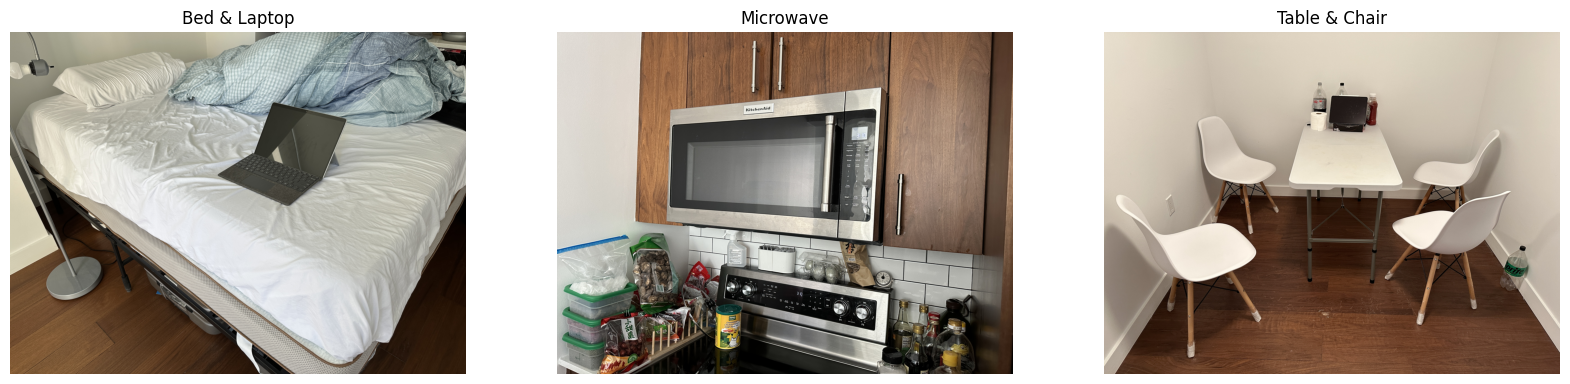

In [22]:
import cv2
import matplotlib.pyplot as plt

img1_path = 'images/bed_laptop.JPG'
img2_path = 'images/microwave.JPG'
img3_path = 'images/table_chair.JPG'

# Read the images
img1 = cv2.imread(img1_path)
img2 = cv2.imread(img2_path)
img3 = cv2.imread(img3_path)

# Convert color from BGR to RGB for displaying with matplotlib
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
img3 = cv2.cvtColor(img3, cv2.COLOR_BGR2RGB)

# Display the images in a row using matplotlib
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

axes[0].imshow(img1)
axes[0].axis('off')
axes[0].set_title('Bed & Laptop')

axes[1].imshow(img2)
axes[1].axis('off')
axes[1].set_title('Microwave')

axes[2].imshow(img3)
axes[2].axis('off')
axes[2].set_title('Table & Chair')

plt.show()

Let's do the inference using the best weights we got. You can use your own images, please specify the actual paths.

In [23]:
!python yolov5/detect.py --weights yolov5/runs/train/exp3/weights/best.pt --source images/bed_laptop.JPG
!python yolov5/detect.py --weights yolov5/runs/train/exp3/weights/best.pt --source images/microwave.JPG
!python yolov5/detect.py --weights yolov5/runs/train/exp3/weights/best.pt --source images/table_chair.JPG

detect: weights=['yolov5/runs/train/exp3/weights/best.pt'], source=images/bed_laptop.JPG, data=yolov5/data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=yolov5/runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
requirements: /home/edward/Desktop/DL_Project/requirements.txt not found, check failed.
YOLOv5 🚀 v7.0-163-g016e046 Python-3.8.16 torch-2.0.0 CUDA:0 (NVIDIA Graphics Device, 24252MiB)

Fusing layers... 
custom_YOLOv5l summary: 267 layers, 46156743 parameters, 0 gradients, 107.8 GFLOPs
image 1/1 /home/edward/Desktop/DL_Project/images/bed_laptop.JPG: 480x640 1 laptop, 1 bed, 37.7ms
Speed: 0.6ms pre-process, 37.7ms inference, 0.6ms NMS per image at shape (1, 3, 640, 640)
Results saved to yolov5/runs/

Let's see the predictions. If you used your own images, please look at the output generated in the previous cell and input the path of your images' predictions.

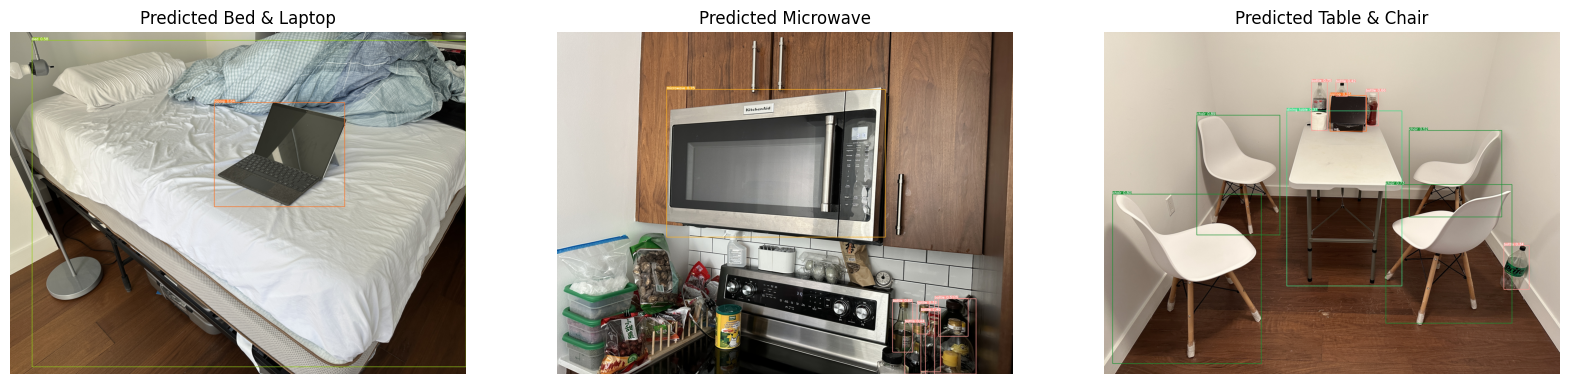

In [24]:
img1_path = 'yolov5/runs/detect/exp2/bed_laptop.JPG'
img2_path = 'yolov5/runs/detect/exp3/microwave.JPG'
img3_path = 'yolov5/runs/detect/exp4/table_chair.JPG'

# Read the images
img1 = cv2.imread(img1_path)
img2 = cv2.imread(img2_path)
img3 = cv2.imread(img3_path)

# Convert color from BGR to RGB for displaying with matplotlib
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
img3 = cv2.cvtColor(img3, cv2.COLOR_BGR2RGB)

# Display the images in a row using matplotlib
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

axes[0].imshow(img1)
axes[0].axis('off')
axes[0].set_title('Predicted Bed & Laptop')

axes[1].imshow(img2)
axes[1].axis('off')
axes[1].set_title('Predicted Microwave')

axes[2].imshow(img3)
axes[2].axis('off')
axes[2].set_title('Predicted Table & Chair')

plt.show()

Let's see some other images and their predictions.

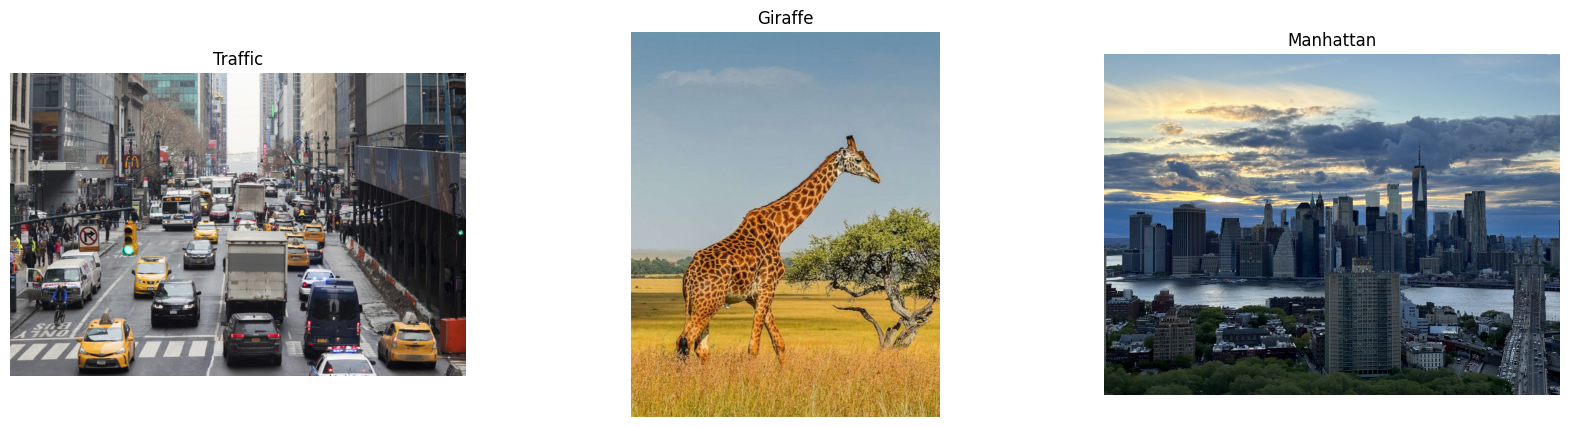

In [25]:
img1_path = 'images/traffic.jpg'
img2_path = 'images/giraffe.jpg'
img3_path = 'images/manhattan.jpg'

# Read the images
img1 = cv2.imread(img1_path)
img2 = cv2.imread(img2_path)
img3 = cv2.imread(img3_path)

# Convert color from BGR to RGB for displaying with matplotlib
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
img3 = cv2.cvtColor(img3, cv2.COLOR_BGR2RGB)

# Display the images in a row using matplotlib
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

axes[0].imshow(img1)
axes[0].axis('off')
axes[0].set_title('Traffic')

axes[1].imshow(img2)
axes[1].axis('off')
axes[1].set_title('Giraffe')

axes[2].imshow(img3)
axes[2].axis('off')
axes[2].set_title('Manhattan')

plt.show()

In [26]:
!python yolov5/detect.py --weights yolov5/runs/train/exp3/weights/best.pt --source images/traffic.jpg
!python yolov5/detect.py --weights yolov5/runs/train/exp3/weights/best.pt --source images/giraffe.jpg
!python yolov5/detect.py --weights yolov5/runs/train/exp3/weights/best.pt --source images/manhattan.jpg

detect: weights=['yolov5/runs/train/exp3/weights/best.pt'], source=images/traffic.jpg, data=yolov5/data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=yolov5/runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
requirements: /home/edward/Desktop/DL_Project/requirements.txt not found, check failed.
YOLOv5 🚀 v7.0-163-g016e046 Python-3.8.16 torch-2.0.0 CUDA:0 (NVIDIA Graphics Device, 24252MiB)

Fusing layers... 
custom_YOLOv5l summary: 267 layers, 46156743 parameters, 0 gradients, 107.8 GFLOPs
image 1/1 /home/edward/Desktop/DL_Project/images/traffic.jpg: 448x640 5 persons, 40.7ms
Speed: 0.2ms pre-process, 40.7ms inference, 4.6ms NMS per image at shape (1, 3, 640, 640)
Results saved to yolov5/runs/detect/exp5


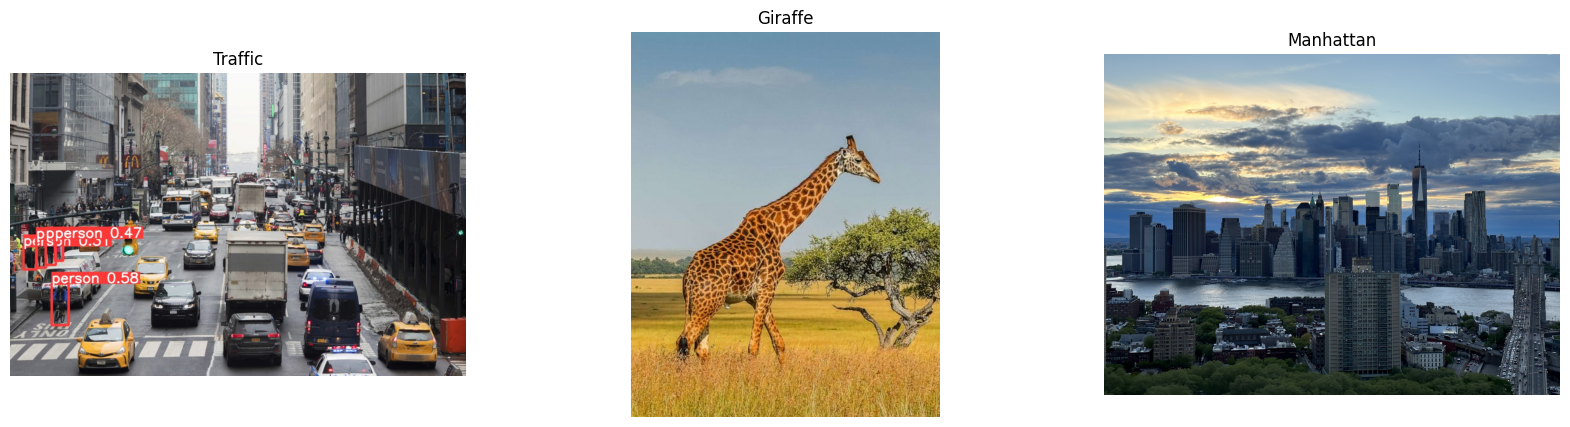

In [27]:
img1_path = 'yolov5/runs/detect/exp5/traffic.jpg'
img2_path = 'yolov5/runs/detect/exp6/giraffe.jpg'
img3_path = 'yolov5/runs/detect/exp7/manhattan.jpg'

# Read the images
img1 = cv2.imread(img1_path)
img2 = cv2.imread(img2_path)
img3 = cv2.imread(img3_path)

# Convert color from BGR to RGB for displaying with matplotlib
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
img3 = cv2.cvtColor(img3, cv2.COLOR_BGR2RGB)

# Display the images in a row using matplotlib
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

axes[0].imshow(img1)
axes[0].axis('off')
axes[0].set_title('Traffic')

axes[1].imshow(img2)
axes[1].axis('off')
axes[1].set_title('Giraffe')

axes[2].imshow(img3)
axes[2].axis('off')
axes[2].set_title('Manhattan')

plt.show()

As you can see, it only detected several person in the first image, which is as expected.